<H1>Required Imports<h1>

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score


<H1>The Dataset</h1>
<H4>Dataset Used : Stock Prices of S&P 500 Index at Stock Exchanges of United States</h4>


In [40]:
snp500=yf.Ticker("^GSPC")
snp500=snp500.history(period="max")
type(snp500)

snp500


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-10-02 00:00:00-04:00,4284.520020,4300.580078,4260.209961,4288.390137,3938660000,0.0,0.0
2023-10-03 00:00:00-04:00,4269.750000,4281.149902,4216.450195,4229.450195,3953830000,0.0,0.0
2023-10-04 00:00:00-04:00,4233.830078,4268.500000,4220.479980,4263.750000,3777600000,0.0,0.0


<br></br>
<br></br>

<h1>Data Cleaning and Data Preparation</h1>
<p>To clean the data we erased the Dividends and Stock Splits columns as we did not used them</p>
<p>To prepare the data we added a column which gives us direction of market for the next day</p>

<Axes: xlabel='Date'>

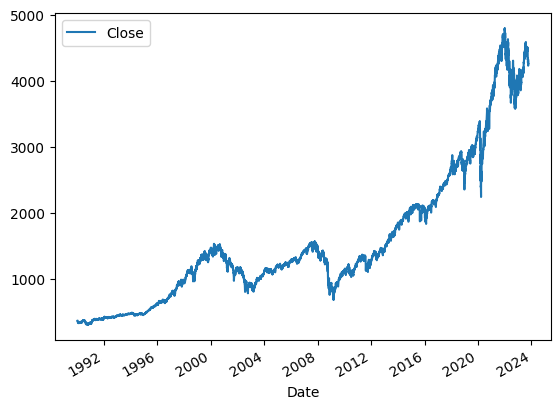

In [41]:
del snp500["Dividends"]
del snp500["Stock Splits"]
snp500["nxt"]=snp500["Close"].shift(-1)
snp500['Tomorrow direction']=(snp500["Close"]<snp500["nxt"]).astype(int)
snp500=snp500.loc['1990-01-01 00:00:00-05:00':].copy()
snp500.plot.line(y='Close',use_index=True)

<br></br>
<br></br>
<h1>The Model : Random Forest Classifier</h1>
<p>This Model is designed to <b>predict the direction of the market</b> not the exact value</p>

In [54]:
model=RandomForestClassifier(n_estimators=200,min_samples_split=100,random_state=1)
train=snp500[:-100]
test=snp500[-100:]
predictors=["Close","High","Low","Volume","Open"]
predictee="Tomorrow direction"

In [55]:
def predict(model,train,test):
    model.fit(train[predictors],train[predictee])
    preds=model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6]=1
    preds[preds<.6]=0
    preds=pd.Series(preds,index=test.index,name="Predictions")
    combined=pd.concat([test[predictee],preds],axis=1)
    return combined

precision_score=  72.72727272727273 %


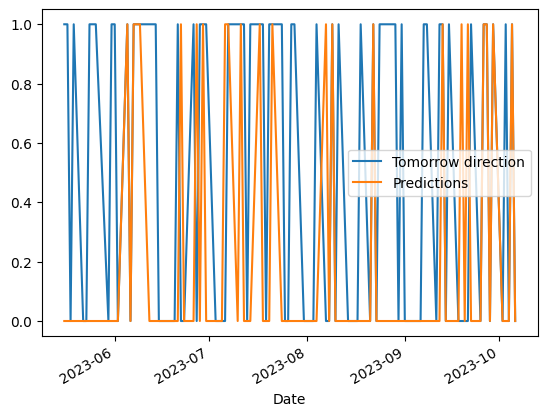

In [57]:
a=predict(model=model,train=train,test=test)
a.plot()
print("precision_score= ",100*precision_score(a["Tomorrow direction"],a["Predictions"]),"%")

<H4>The Result</H4>
<p>We used the entire data and predicted at what day will we have positive directions in the market,the result seems to be far-fetched (a bit too precise) so we perform backtesting to get more accurate measures in order to better judge the model</p>

<br></br>
<br></br>
<br></br>
<h1>Back Testing</h1>
<p>In general to gain confidence on a model we use backtesting. In this process we build a model on a few years of data and test it on few next days and then we increase the 
data set to a few more years ahead and test our model on next few days doing this will get us more parameters or more data set to judge our model based on how our model did to predict past values using the data even before it.</p>

In [58]:

def BackTest(data,model,start=2500,step=250):
    allpredictions=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions=predict(model=model,train=train,test=test)
        allpredictions.append(predictions)
    
    return pd.concat(allpredictions)


In [61]:
predictions=BackTest(snp500,model=model,start=2500,step=100)

In [64]:
print("precision_score= ",100*precision_score(predictions["Tomorrow direction"],predictions["Predictions"]),"%")


precision_score=  53.403643336529235 %


Now, After Using Backtesting we see that the model is precise only about 53% of times. Now, we have another problem that the model is not performing good enough so we increase the number of parameters by which our model can better predict the result.

<br></br>
<br></br>
<h1>Increasing The number of predictors used</h1>
<p>We will do this by taking rolling averages of the market closing values for few past days ,weeks ,quarters and years to get better output</p>
<p>and by picking up on trends in last few days ,weeks ,quarters and years </p>

In [65]:
lookBack=[2,5,63,125,188,250,500,750,1000]
newPredictors=predictors.copy()
for days in lookBack:
    rolling_averages=snp500.rolling(days).mean()
    ratio_column=f"lookBack Days :{days}"
    snp500[ratio_column]=snp500["Close"]/rolling_averages["Close"]
    trend_Column=f"Trend Days :{days}"
    snp500[trend_Column]=snp500.shift(1).rolling(days).sum()["Tomorrow direction"]
    newPredictors+=[ratio_column,trend_Column]
   
   
    

In [66]:
def newpredict(model,train,test):
    model.fit(train[newPredictors],train[predictee])
    preds=model.predict_proba(test[newPredictors])[:,1]
    preds[preds>=.66]=1
    preds[preds<.66]=0
    preds=pd.Series(preds,index=test.index,name="Predictions")
    combined=pd.concat([test[predictee],preds],axis=1)
    return combined

def newBackTest(data,model,start=2500,step=250):
    allpredictions=[]
    for i in range(start,data.shape[0],step):
        train=data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions=newpredict(model=model,train=train,test=test)
        allpredictions.append(predictions)
    
    return pd.concat(allpredictions)

In [67]:
snp500=snp500.dropna()
snp500

,Open,High,Low,Close,Volume,nxt,Tomorrow direction,lookBack Days :2,Trend Days :2,lookBack Days :5,...,lookBack Days :188,Trend Days :188,lookBack Days :250,Trend Days :250,lookBack Days :500,Trend Days :500,lookBack Days :750,Trend Days :750,lookBack Days :1000,Trend Days :1000
Date,,,,,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,...,1.021147,96.0,1.028047,127.0,1.070428,259.0,1.119989,380.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,...,1.018318,96.0,1.025151,126.0,1.067300,258.0,1.116559,379.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,...,1.021452,97.0,1.028274,127.0,1.070477,258.0,1.119705,379.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,...,1.027941,98.0,1.034781,128.0,1.077202,258.0,1.126544,380.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,...,1.026559,98.0,1.033359,128.0,1.075726,257.0,1.124742,380.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-29 00:00:00-04:00,4328.180176,4333.149902,4274.859863,4288.049805,3865960000,4288.390137,1,0.998643,1.0,0.998464,...,1.015968,97.0,1.038452,123.0,1.018903,243.0,1.034344,381.0,1.103394,531.0
2023-10-02 00:00:00-04:00,4284.520020,4300.580078,4260.209961,4288.390137,3938660000,4229.450195,0,1.000040,1.0,1.000829,...,1.015475,98.0,1.037921,123.0,1.019012,243.0,1.034137,381.0,1.103098,531.0
2023-10-03 00:00:00-04:00,4269.750000,4281.149902,4216.450195,4229.450195,3953830000,4263.750000,1,0.993080,1.0,0.989109,...,1.001007,98.0,1.023222,122.0,1.005071,242.0,1.019667,380.0,1.087585,530.0


In [71]:

predictions=newBackTest(snp500,model=model,start=2500,step=100)


In [72]:
print("precision_score= ",100*precision_score(predictions["Tomorrow direction"],predictions["Predictions"]),"%")

precision_score=  57.63358778625955 %


<h1>The Final Result</h1>
<h4>Now we have got precision of about 57.6% which can be expected from simple random forest classifier model</h4>